In [1]:
%load_ext jupyter_black
import pandas as pd
import numpy as np  
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df_train = pd.read_csv("test_data_scientist/train.csv.gz", compression="gzip")
df_test = pd.read_csv("test_data_scientist/test.csv.gz", compression="gzip")
df_bu_feat = pd.read_csv("test_data_scientist/bu_feat.csv.gz", compression="gzip")

print(df_train.shape)
print(df_train.head())


print(df_test.shape)
print(df_test.head())

print(df_bu_feat.shape)
print(df_bu_feat.head())

(277719, 4)
       day_id  but_num_business_unit  dpt_num_department     turnover
0  2017-09-30                     64                 127   580.308443
1  2017-09-30                    119                 127  1512.995918
2  2017-09-30                      4                  88   668.593556
3  2017-09-30                    425                 127     0.000000
4  2017-09-30                    513                  73     0.000000
(10136, 3)
       day_id  but_num_business_unit  dpt_num_department
0  2017-11-25                     95                  73
1  2017-11-25                      4                 117
2  2017-11-25                    113                 127
3  2017-11-25                     93                 117
4  2017-11-25                     66                 127
(326, 6)
   but_num_business_unit  but_postcode  but_latitude  but_longitude  \
0                   1609         80100     50.096306       1.867220   
1                   1995         95700     48.991087       2.520

In [3]:
df_test

,day_id,but_num_business_unit,dpt_num_department
0,2017-11-25,95,73
1,2017-11-25,4,117
2,2017-11-25,113,127
3,2017-11-25,93,117
4,2017-11-25,66,127
...,...,...,...
10131,2017-10-07,61,88
10132,2017-10-07,641,117
10133,2017-10-07,724,117
10134,2017-10-07,1302,117


In [4]:
df_merged_train = df_train.merge(
    df_bu_feat,
    on="but_num_business_unit",
    how="left",  # keeps all rows from df_train_sample
)

df_merged_test = df_test.merge(
    df_bu_feat,
    on="but_num_business_unit",
    how="left",  # keeps all rows from df_train_sample
)


df_merged_test

,day_id,but_num_business_unit,dpt_num_department,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
0,2017-11-25,95,73,80000,49.869382,2.280452,69,4
1,2017-11-25,4,117,6600,43.600994,7.078160,55,10
2,2017-11-25,113,127,84014,43.919562,4.867583,115,10
3,2017-11-25,93,117,13008,43.239744,5.396694,71,10
4,2017-11-25,66,127,34500,43.347835,3.255024,6,10
...,...,...,...,...,...,...,...,...
10131,2017-10-07,61,88,60740,49.238738,2.468513,69,4
10132,2017-10-07,641,117,17810,45.749749,-0.675981,70,10
10133,2017-10-07,724,117,38150,45.327709,4.804922,52,4
10134,2017-10-07,1302,117,74950,46.069548,6.549448,51,4


In [5]:
df_merged_train["day_id"] = pd.to_datetime(df_merged_train["day_id"])

df_merged_train = df_merged_train.sort_values(
    ["but_num_business_unit", "dpt_num_department", "day_id"]
).reset_index(drop=True)

# Create day-of-year features for seasonality
# Extract ISO week number (1-52)
df_merged_train["week_of_year"] = df_merged_train["day_id"].dt.isocalendar().week
df_merged_train["sin_week"] = np.sin(2 * np.pi * df_merged_train["week_of_year"] / 52)
df_merged_train["cos_week"] = np.cos(2 * np.pi * df_merged_train["week_of_year"] / 52)
df_merged_train["day_of_year"] = df_merged_train["day_id"].dt.dayofyear
df_merged_train["sin_day"] = np.sin(2 * np.pi * df_merged_train["day_of_year"] / 365)
df_merged_train["cos_day"] = np.cos(2 * np.pi * df_merged_train["day_of_year"] / 365)


df_merged_train

,day_id,but_num_business_unit,dpt_num_department,turnover,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr,week_of_year,sin_week,cos_week,day_of_year,sin_day,cos_day
0,2012-12-29,1,73,15.552508,59320,50.628060,2.957377,65,4,52,0.0,1.0,364,-0.017213,0.999852
1,2013-01-05,1,73,8.092452,59320,50.628060,2.957377,65,4,1,0.120537,0.992709,5,0.085965,0.996298
2,2013-01-12,1,73,15.985334,59320,50.628060,2.957377,65,4,2,0.239316,0.970942,12,0.205104,0.978740
3,2013-01-19,1,73,17.041977,59320,50.628060,2.957377,65,4,3,0.354605,0.935016,19,0.321270,0.946988
4,2013-01-26,1,73,5.499308,59320,50.628060,2.957377,65,4,4,0.464723,0.885456,26,0.432776,0.901502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277714,2017-09-02,1887,127,7.203919,59240,51.050275,2.393182,65,4,35,-0.885456,-0.464723,245,-0.880012,-0.474951
277715,2017-09-09,1887,127,0.000000,59240,51.050275,2.393182,65,4,36,-0.935016,-0.354605,252,-0.930724,-0.365723
277716,2017-09-16,1887,127,0.000000,59240,51.050275,2.393182,65,4,37,-0.970942,-0.239316,259,-0.967938,-0.251190
277717,2017-09-23,1887,127,0.000000,59240,51.050275,2.393182,65,4,38,-0.992709,-0.120537,266,-0.991114,-0.133015


In [6]:
lags = [1, 3, 5, 11, 25]


def create_lags_and_rollings(group, lags=lags, windows=[3, 11, 25]):
    group = group.sort_values("day_id")  # sort time
    for lag in lags:
        group[f"lag_{lag}"] = group["turnover"].shift(lag)
    for window in windows:
        group[f"rolling_mean_{window}"] = (
            group["turnover"].shift(1).rolling(window=window).mean()
        )
        group[f"rolling_std_{window}"] = (
            group["turnover"].shift(1).rolling(window=window).std()
        )
    return group


df_merged_train = (
    df_merged_train.groupby(["but_num_business_unit", "dpt_num_department"])
    .apply(create_lags_and_rollings)
    .reset_index(drop=True)
)

df = df_merged_train.sort_values(by="day_id")
# df = df.dropna()

df_filtered = df[(df["but_num_business_unit"] == 1) & (df["dpt_num_department"] == 73)]
df_filtered

/tmp/ipykernel_57329/1323711750.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(create_lags_and_rollings)


,day_id,but_num_business_unit,dpt_num_department,turnover,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr,week_of_year,...,lag_3,lag_5,lag_11,lag_25,rolling_mean_3,rolling_std_3,rolling_mean_11,rolling_std_11,rolling_mean_25,rolling_std_25
0,2012-12-29,1,73,15.552508,59320,50.62806,2.957377,65,4,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-05,1,73,8.092452,59320,50.62806,2.957377,65,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-12,1,73,15.985334,59320,50.62806,2.957377,65,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-19,1,73,17.041977,59320,50.62806,2.957377,65,4,3,...,15.552508,NaN,NaN,NaN,13.210098,4.437292,NaN,NaN,NaN,NaN
4,2013-01-26,1,73,5.499308,59320,50.62806,2.957377,65,4,4,...,8.092452,NaN,NaN,NaN,13.706588,4.890604,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2017-09-02,1,73,38.912414,59320,50.62806,2.957377,65,4,35,...,54.633985,52.319858,76.687149,11.498496,40.695624,16.096496,59.279283,18.807861,50.584528,18.999893
245,2017-09-09,1,73,36.114297,59320,50.62806,2.957377,65,4,36,...,44.374859,56.700873,47.333458,21.296195,35.455100,11.061352,55.845216,18.760093,51.681085,17.371387
246,2017-09-16,1,73,24.852552,59320,50.62806,2.957377,65,4,37,...,23.078028,54.633985,83.229435,27.077381,32.701580,8.450853,54.825293,19.557166,52.273809,16.523547
247,2017-09-23,1,73,15.530263,59320,50.62806,2.957377,65,4,38,...,38.912414,44.374859,79.667993,29.919988,33.293088,7.442402,49.518303,18.991029,52.184816,16.670245


In [7]:
# Drop rows with NaN due to lags
df = df.drop(columns=["day_id"])

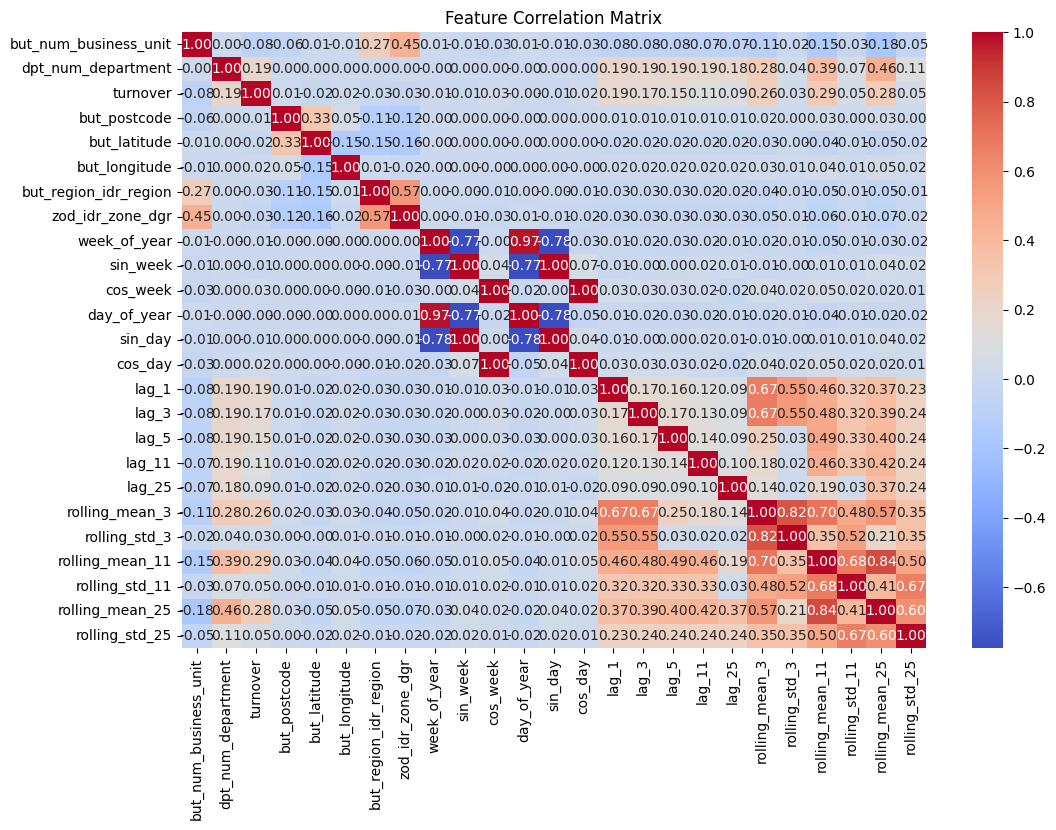

In [8]:
feature_cols = [col for col in df.columns if col != "turnover" or "day_of_year"]
X = df[feature_cols]
y = df["turnover"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)


corr_matrix = df[feature_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [9]:
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=32,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)

[0]	validation_0-rmse:829.43708
[50]	validation_0-rmse:502.85883
[100]	validation_0-rmse:306.97977
[150]	validation_0-rmse:188.23808
[200]	validation_0-rmse:128.35406
[250]	validation_0-rmse:105.47403
[300]	validation_0-rmse:94.43296
[350]	validation_0-rmse:92.47761
[381]	validation_0-rmse:90.57245


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


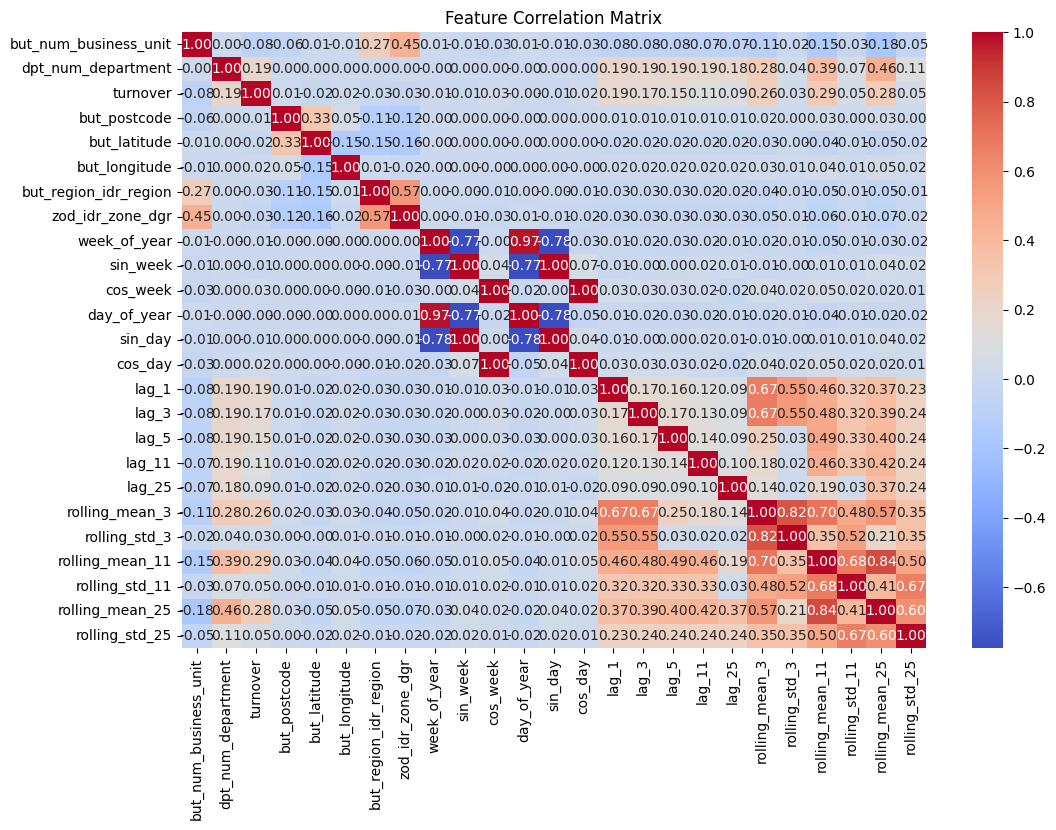

In [10]:
# Compute correlation matrix
corr_matrix = df[feature_cols].corr()

# Visualize
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [11]:
# Predict
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 25.98
RMSE: 90.09
R²: 0.99


# WRONG

In [12]:
# Determine split index
split_idx = int(len(df) * 0.8)

# Split
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
)


model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=10)

Training samples: 222175, Testing samples: 55544
[0]	validation_0-rmse:867.19750
[10]	validation_0-rmse:786.21314
[20]	validation_0-rmse:713.97561
[30]	validation_0-rmse:647.13401
[40]	validation_0-rmse:589.41294
[50]	validation_0-rmse:537.10717
[60]	validation_0-rmse:492.20876
[70]	validation_0-rmse:460.86705
[80]	validation_0-rmse:430.38770
[90]	validation_0-rmse:397.80714
[100]	validation_0-rmse:368.13944
[110]	validation_0-rmse:341.22355
[120]	validation_0-rmse:328.38435
[130]	validation_0-rmse:308.22477
[140]	validation_0-rmse:290.81792
[150]	validation_0-rmse:275.60400
[160]	validation_0-rmse:270.33154
[170]	validation_0-rmse:271.62013
[180]	validation_0-rmse:262.62229
[190]	validation_0-rmse:255.29442
[200]	validation_0-rmse:261.30403
[210]	validation_0-rmse:268.20760
[220]	validation_0-rmse:264.16392
[230]	validation_0-rmse:260.74581
[240]	validation_0-rmse:269.36647


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [13]:
# Predict
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 88.37
RMSE: 255.29
R²: 0.91


In [14]:
# Faire un DataFrame avec les vraies valeurs et les prédictions
results = pd.DataFrame(
    {
        "department": X_test["dpt_num_department"].values,
        "y_true": y_test.values,
        "y_pred": y_pred,
    }
)


# Fonction pour calculer MAE et RMSE
def compute_metrics(group):
    mae = mean_absolute_error(group["y_true"], group["y_pred"])
    rmse = np.sqrt(mean_squared_error(group["y_true"], group["y_pred"]))
    return pd.Series({"MAE": mae, "RMSE": rmse})


# Calcul par département
metrics_by_dept = results.groupby("department").apply(compute_metrics).reset_index()

print(metrics_by_dept)

   department         MAE        RMSE
0          73   74.707295   76.394656
1          88   51.134015  415.150968
2         117  104.190290  203.000626
3         127  123.989248  198.614844


/tmp/ipykernel_57329/2336004831.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_dept = results.groupby("department").apply(compute_metrics).reset_index()
